In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import warnings
import os
from tqdm import tqdm
import math
from PIL import Image, ImageDraw, ImageFont


In [2]:
files = os.listdir("h5_by_celltype_clustered/")

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


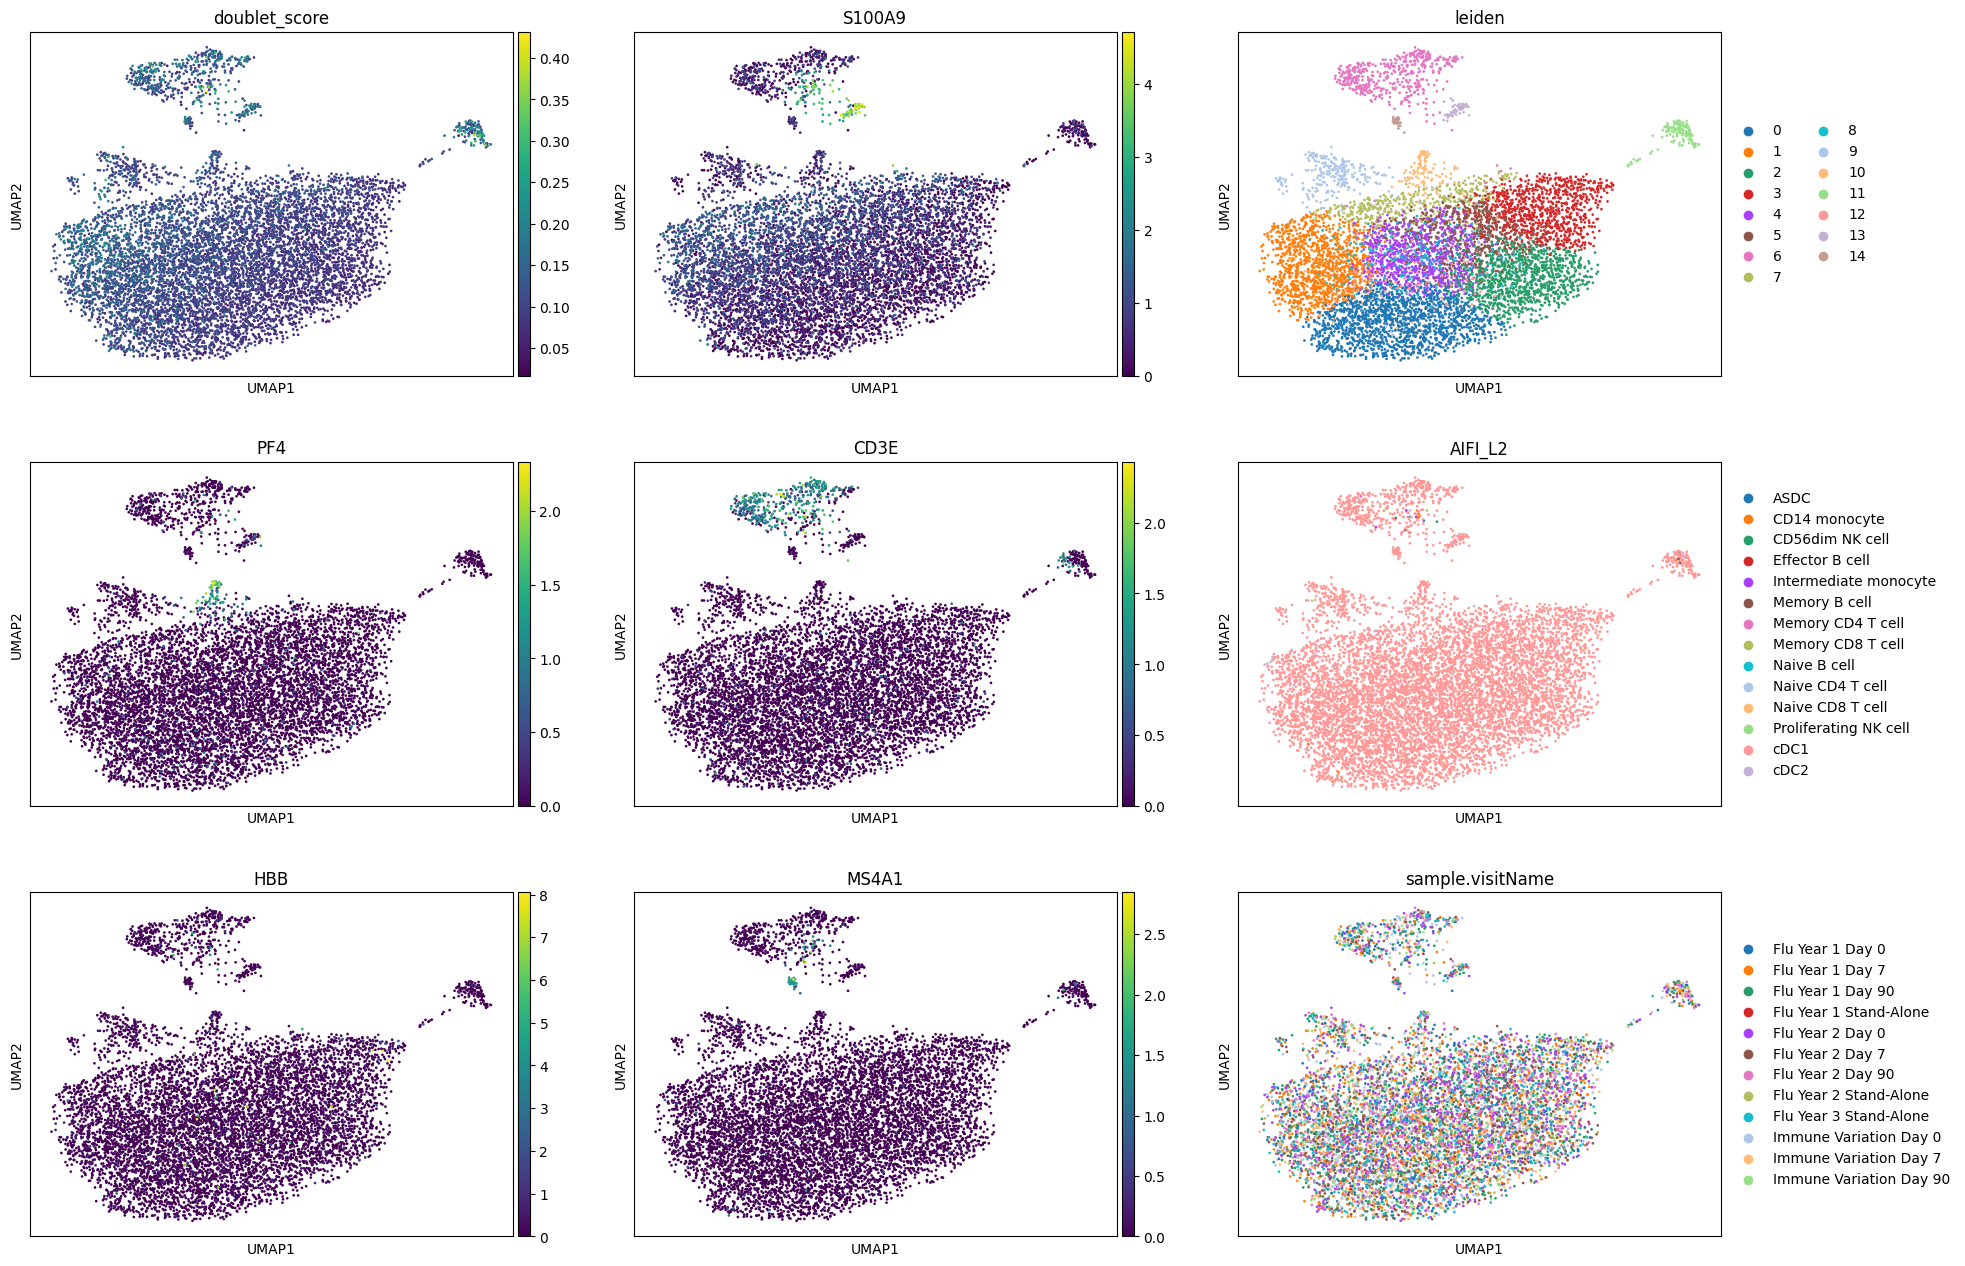

/tmp/ipykernel_109851/1734142693.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_109851/1734142693.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('group')
/tmp/ipykernel_109851/1734142693.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.suptitle(adata.obs['AIFI_L3'][0], fontsize=50)
/tmp/ipykernel_109851/1734142693.py

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


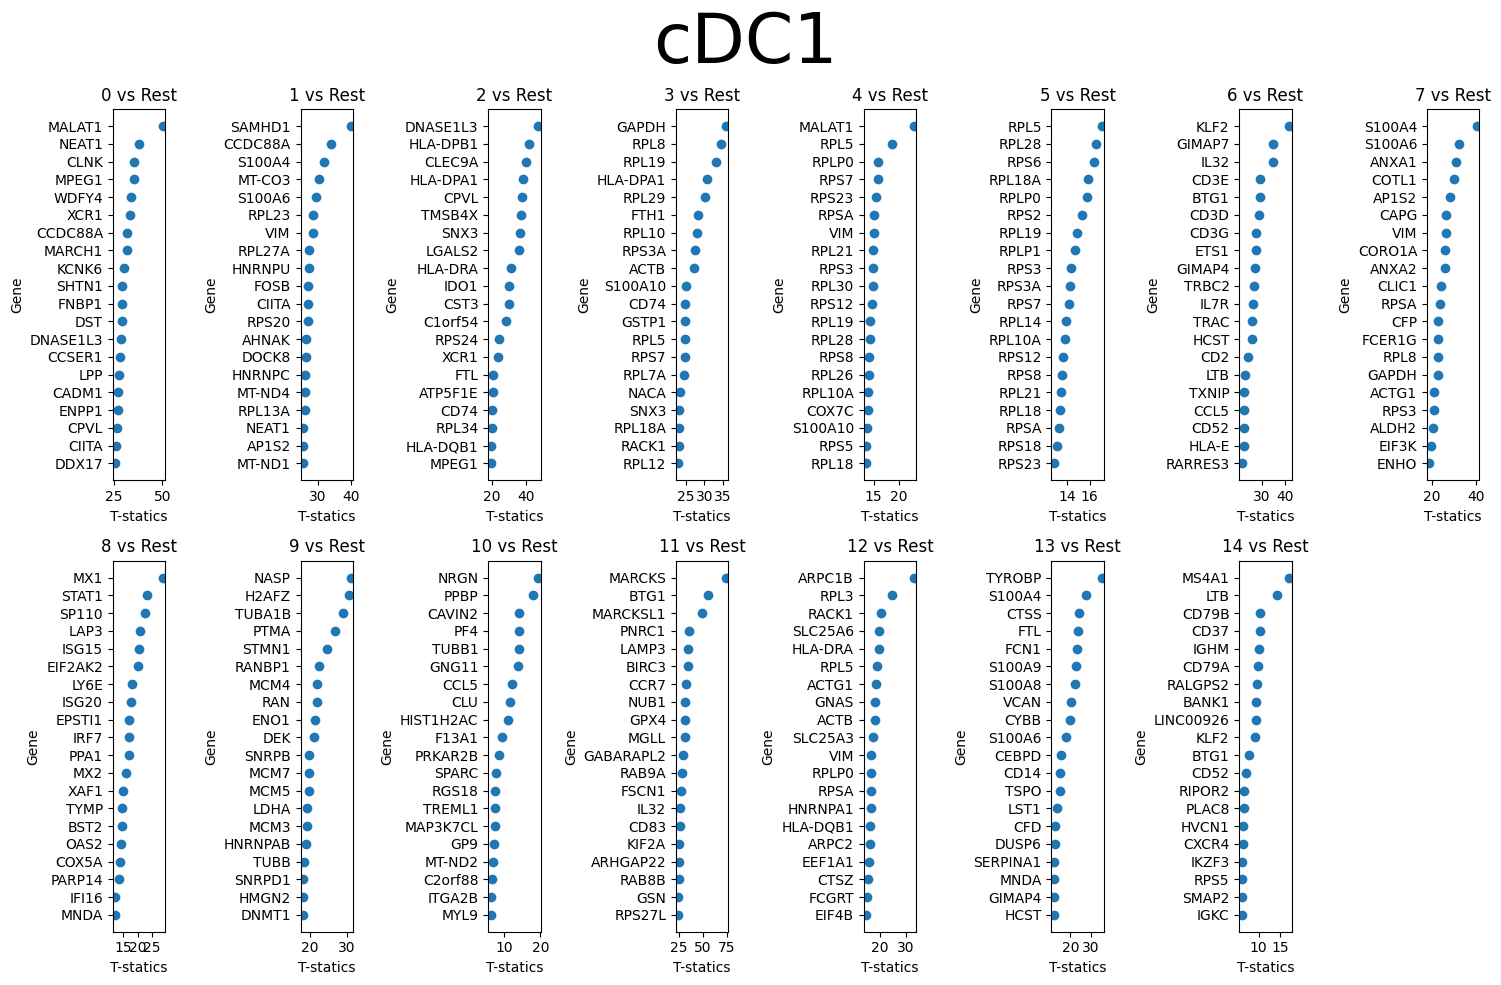

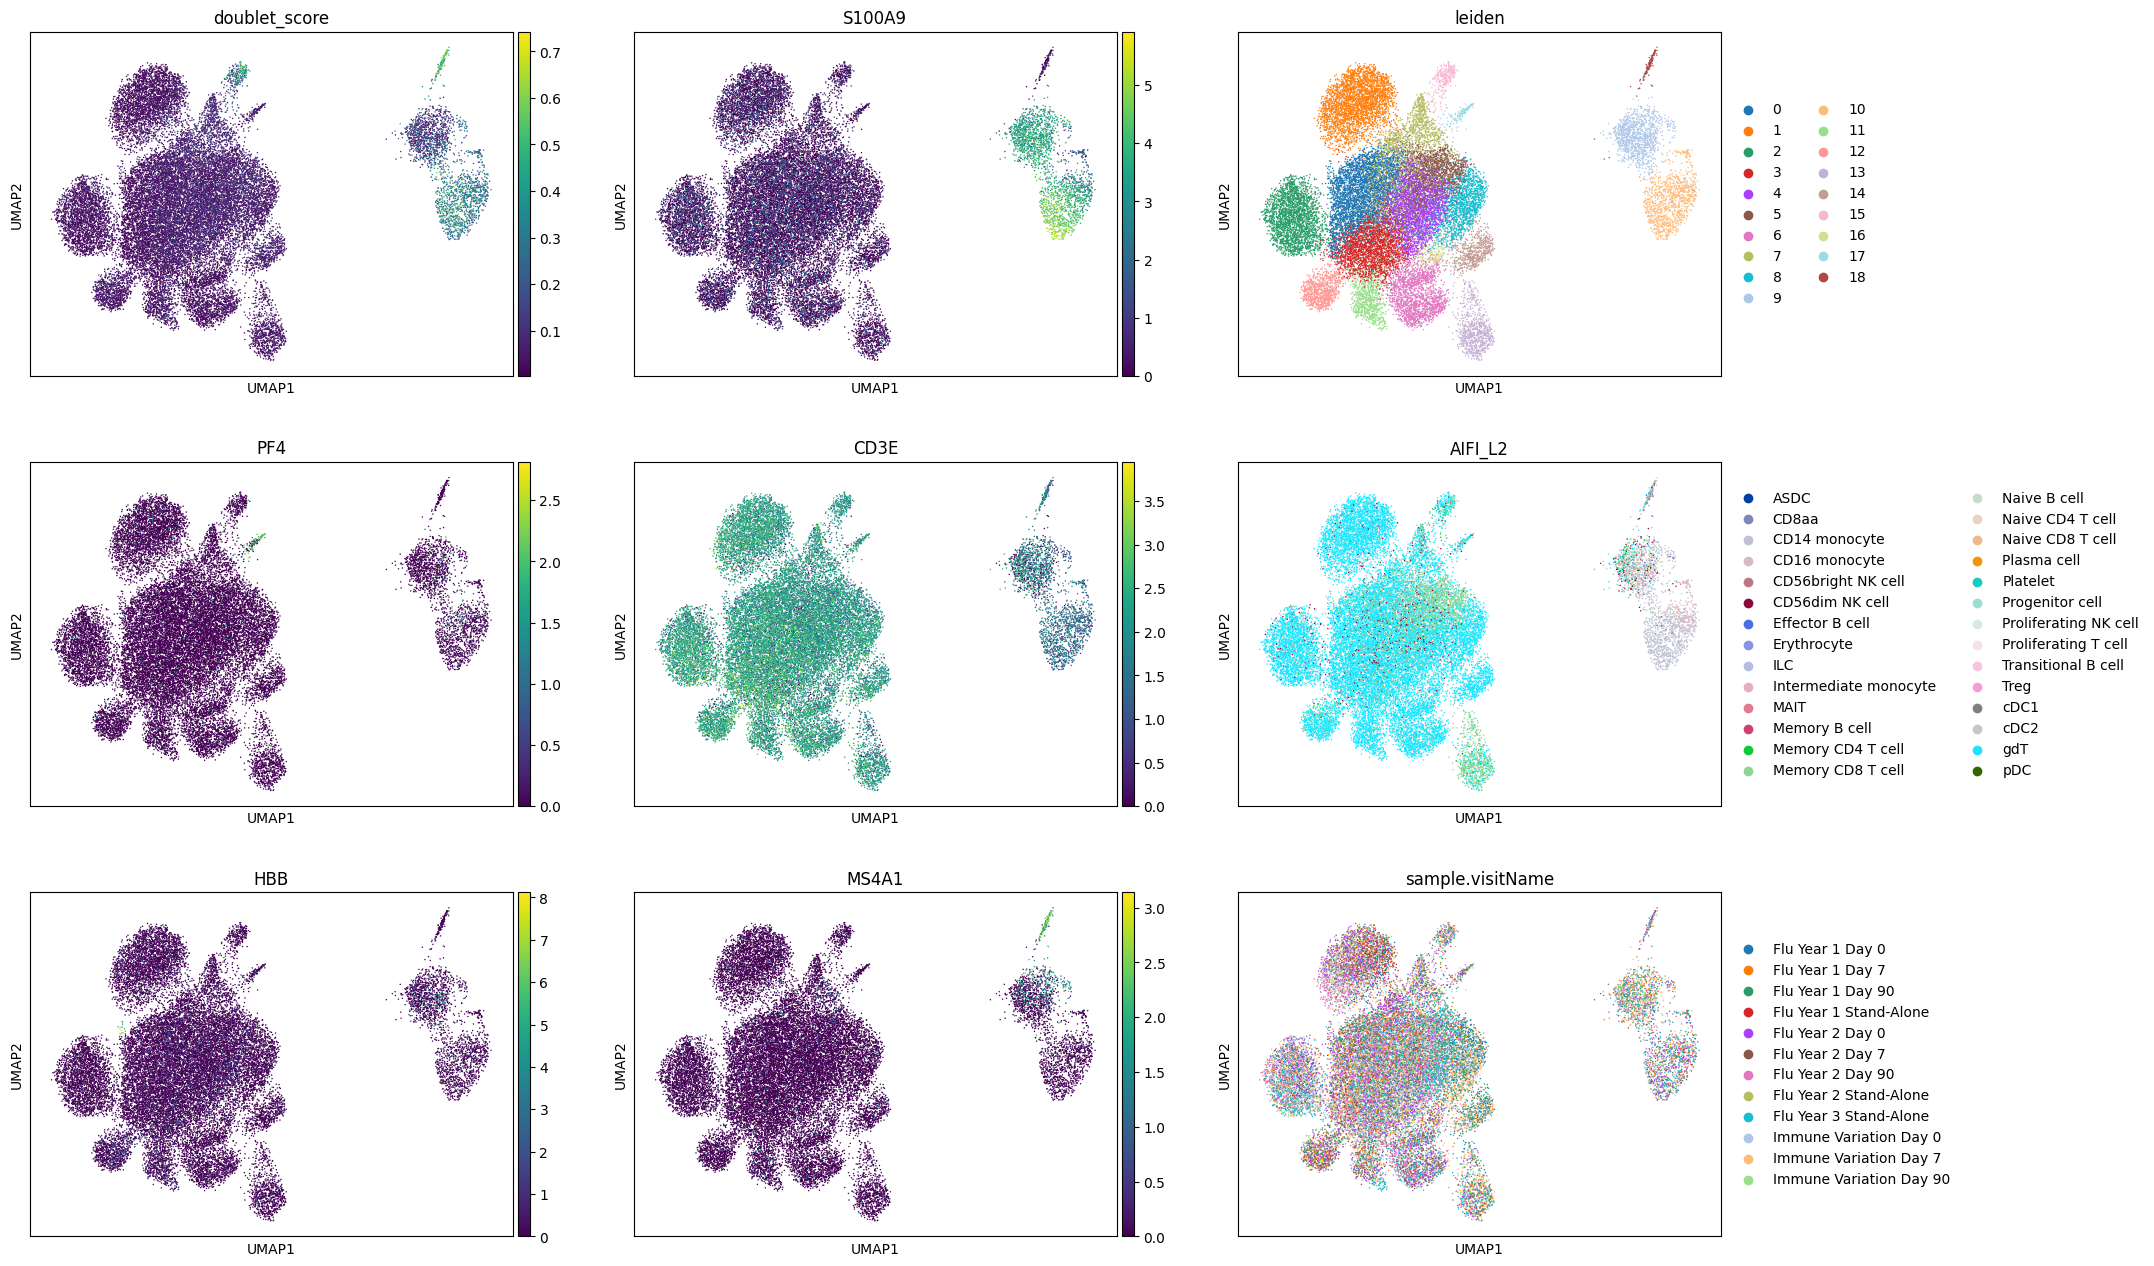

/tmp/ipykernel_109851/1734142693.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_109851/1734142693.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('group')
/tmp/ipykernel_109851/1734142693.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.suptitle(adata.obs['AIFI_L3'][0], fontsize=50)
/tmp/ipykernel_109851/1734142693.py

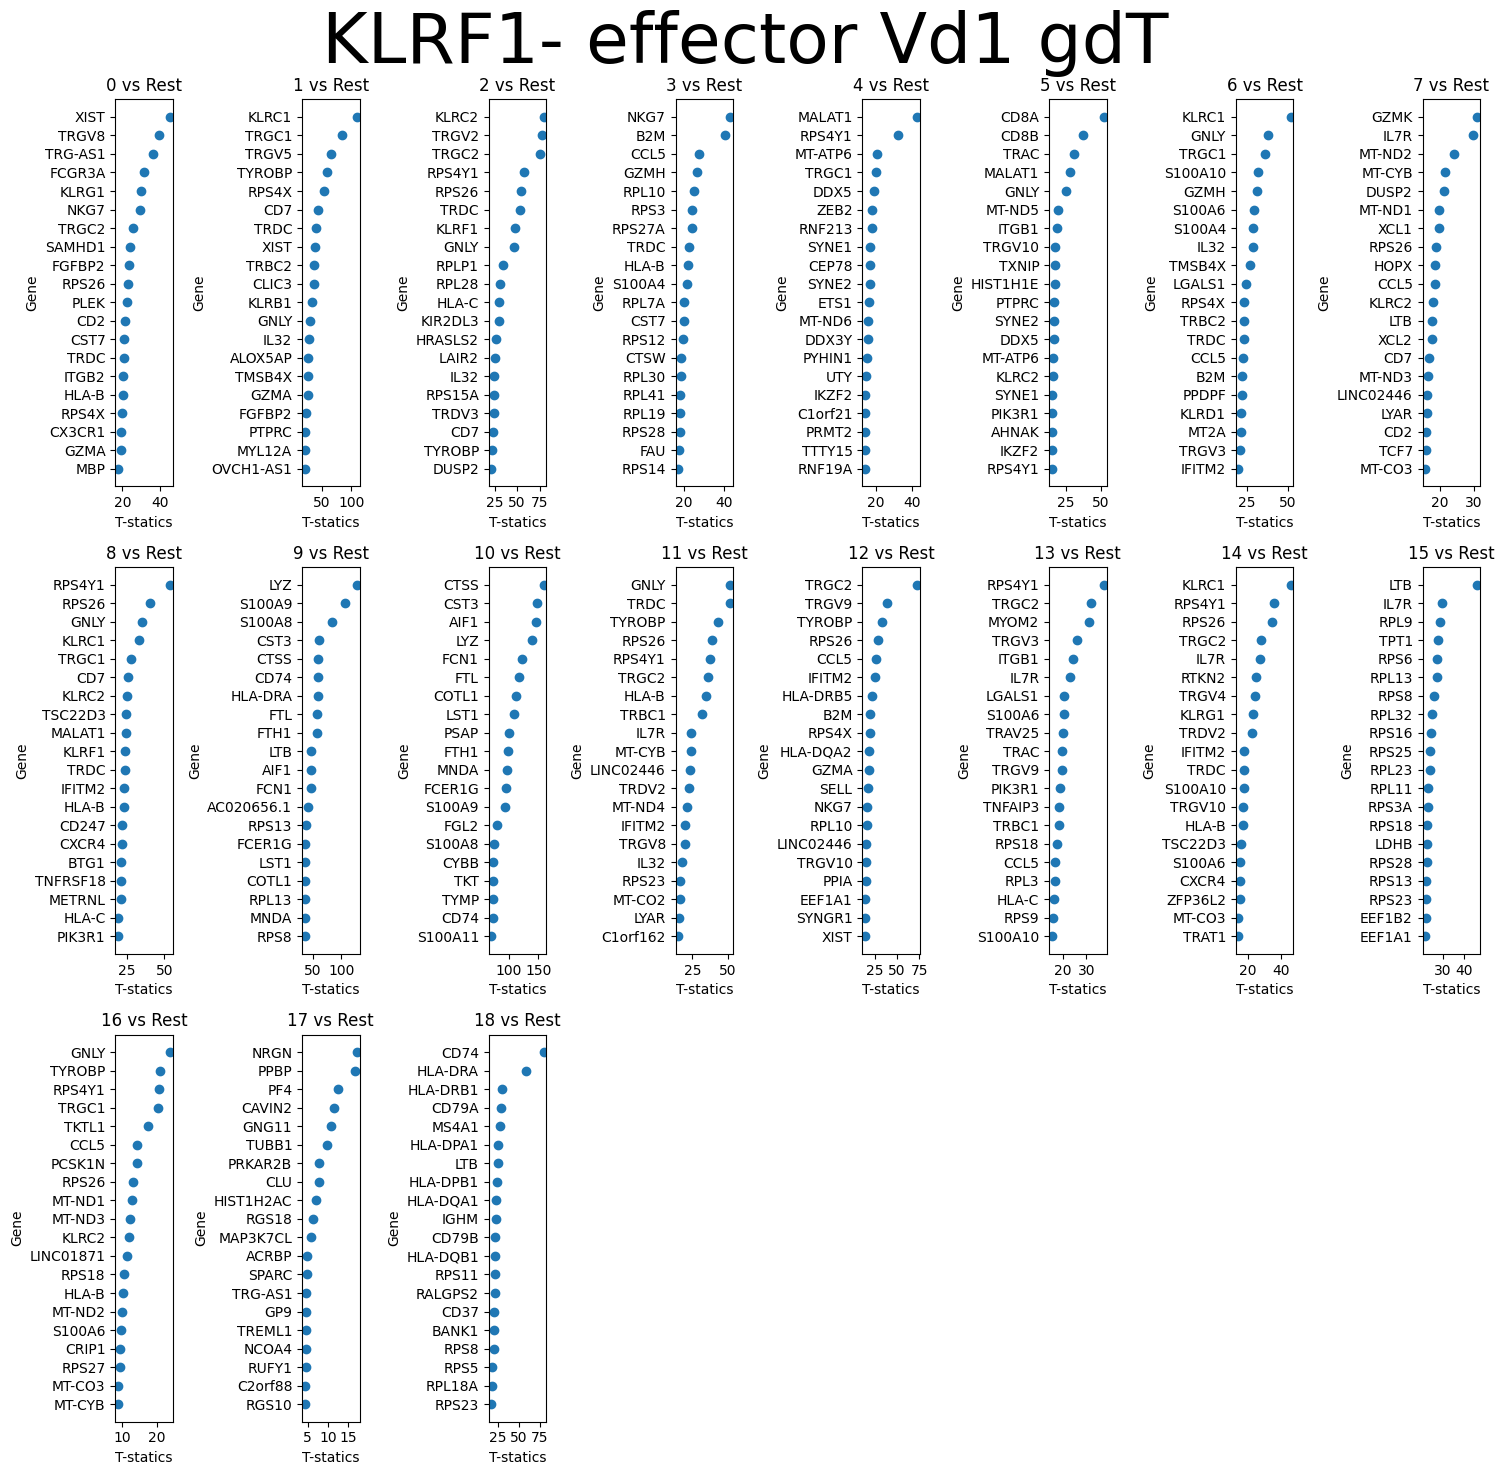

In [3]:
for i in files[0:2]:
    adata=sc.read_h5ad('h5_by_celltype_clustered/'+i)
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
    sc.pl.umap(adata, color=['doublet_score', 'S100A9', 'leiden',
                             'PF4', 'CD3E', 'AIFI_L2', 
                             'HBB', 'MS4A1', 'sample.visitName'], ncols=3, save='_UMAP.png')

    df = sc.get.rank_genes_groups_df(adata, group=None)
    df = df.groupby('group').head(20).reset_index(drop=True)
    groups = df.groupby('group')

    n_groups = len(groups)
    n_cols = 8
    n_rows = math.ceil(n_groups / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))  
    fig.suptitle(adata.obs['AIFI_L3'][0], fontsize=50)
    for ax in axs.flat:
        ax.set_visible(False)

    for i, (name, group) in enumerate(groups):
        row, col = divmod(i, n_cols)
        ax = axs[row, col]
        ax.set_visible(True)
        ax.scatter(group['scores'], group['names'])
        ax.invert_yaxis()
        ax.set_title(str(name) + " vs Rest")
        ax.set_xlabel('T-Statistics')
        ax.set_ylabel('Gene')

    plt.tight_layout()
    plt.savefig('scatter_plots.png')

    img2 = Image.open('figures/umap_UMAP.png')
    img1 = Image.open('scatter_plots.png')

    total_width = max(img1.width, img2.width)
    font_size = 20 
    title_height = font_size * 2  
    total_height = img1.height + img2.height + title_height

    combined_img = Image.new('RGB', (total_width, total_height), 'white')  

    draw = ImageDraw.Draw(combined_img)


    combined_img.paste(img1, (0, title_height))
    combined_img.paste(img2, (0, title_height + img1.height))

    combined_img.save('Doublet_QC_Plots/'+adata.obs['AIFI_L3'][0]+'.png')

In [5]:
files = os.listdir("Doublet_QC_Plots/")

def pngs_to_pdf(png_files, output_pdf):
    # Ensure there are PNG files in the list
    if not png_files:
        print("No PNG files to convert.")
        return

    # Convert all PNG images to RGBA if they are not
    images = [Image.open(png).convert('RGBA') for png in png_files]

    # Convert RGBA images to RGB
    rgb_images = [Image.new("RGB", image.size, (255, 255, 255)) for image in images]
    for rgb_image, image in zip(rgb_images, images):
        rgb_image.paste(image, mask=image.split()[3])  # 3 is the alpha channel

    # Save all the images as a PDF
    rgb_images[0].save(output_pdf, save_all=True, append_images=rgb_images[1:])

# List of PNG files
png_files = ['Doublet_QC_Plots/'+i for i in files]  # Replace with your file paths
output_pdf = 'output.pdf'  # Output file name

pngs_to_pdf(png_files, output_pdf)
